In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Package imports

In [2]:
#pip install opencv-python

In [3]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
from google.colab.patches import cv2_imshow

### Data loading and pre-processing

In [4]:
# files available from the Sign Language MNIST Dataset
for dirname, _, filenames in os.walk('/content/drive/My Drive/Real time Project/archive'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/My Drive/Real time Project/archive/american_sign_language.PNG
/content/drive/My Drive/Real time Project/archive/amer_sign3.png
/content/drive/My Drive/Real time Project/archive/sign_mnist_test.csv
/content/drive/My Drive/Real time Project/archive/amer_sign2.png
/content/drive/My Drive/Real time Project/archive/sign_mnist_train.csv
/content/drive/My Drive/Real time Project/archive/sign_mnist_test/sign_mnist_test.csv
/content/drive/My Drive/Real time Project/archive/sign_mnist_train/sign_mnist_train.csv


In [5]:
train_df = pd.read_csv("/content/drive/My Drive/Real time Project/archive/sign_mnist_train.csv")
test_df = pd.read_csv("/content/drive/My Drive/Real time Project/archive/sign_mnist_test.csv")

In [6]:
train_df.shape

(27455, 785)

In [7]:
test_df.shape

(7172, 785)

In [8]:
test = pd.read_csv("/content/drive/My Drive/Real time Project/archive/sign_mnist_test.csv")
y = test['label']

In [9]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,156,158,160,163,165,159,166,168,170,170,171,171,171,172,171,171,170,170,169,111,121,129,135,141,144,148,151,154,157,160,...,205,206,206,207,207,206,206,204,205,204,203,202,142,151,160,172,196,188,188,190,135,96,86,77,77,79,176,205,207,207,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,157,158,156,154,154,153,152,151,149,149,148,147,146,144,142,143,138,92,108,158,159,159,159,160,160,160,160,160,160,160,...,100,78,120,157,168,107,99,121,133,97,95,120,135,116,95,79,69,86,139,173,200,185,175,198,124,118,94,140,133,84,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,186,185,185,185,184,184,184,181,181,179,179,179,178,178,109,52,66,77,83,188,189,189,188,188,189,188,188,188,188,187,...,203,204,203,201,200,200,199,198,196,195,194,193,198,166,132,114,89,74,79,77,74,78,132,188,210,209,206,205,204,203,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,211,209,207,208,207,206,203,202,201,200,198,197,195,192,197,171,51,52,54,212,213,215,215,212,212,213,212,212,211,211,...,247,242,233,231,230,229,227,225,223,221,220,216,58,51,49,50,57,60,17,15,18,17,19,1,159,255,237,239,237,236,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,186,188,189,189,190,191,189,190,190,187,190,192,193,191,191,192,192,194,194,166,169,172,174,177,180,182,185,186,187,190,...,90,77,88,117,123,127,129,134,145,152,156,179,105,106,105,104,104,104,175,199,178,152,136,130,136,150,118,92,85,76,92,105,105,108,133,163,157,163,164,179


In [27]:
y_train = train_df['label']
y_test = test_df['label']
del train_df['label']
del test_df['label']

In [28]:
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.fit_transform(y_test)

In [29]:
x_train = train_df.values
x_test = test_df.values

In [30]:
x_train = x_train / 255
x_test = x_test / 255

In [31]:
x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)

### Data Visualizations

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


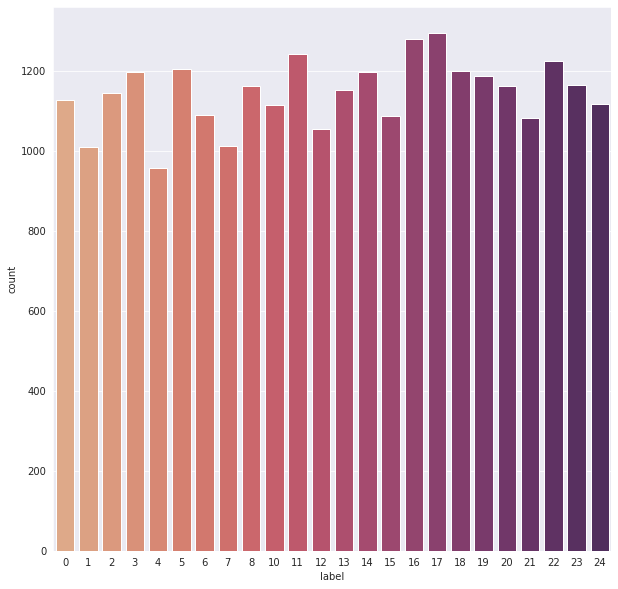

In [26]:
plt.figure(figsize = (10,10))
sns.set_style("darkgrid")
sns.countplot(train_df['label'], palette="flare")

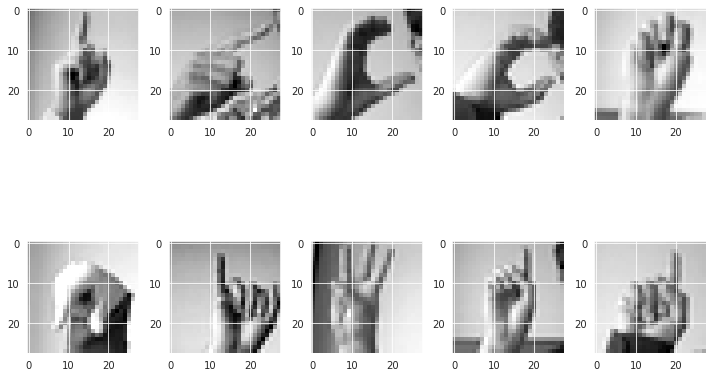

In [33]:
f, ax = plt.subplots(2,5) 
f.set_size_inches(10, 10)
k = 0
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(x_train[k].reshape(28, 28) , cmap = "gray")
        k += 1
    plt.tight_layout()    

### Model training

In [35]:
datagen = ImageDataGenerator(
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

In [37]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)
model = Sequential()
model.add(Conv2D(75 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (28,28,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(50 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(25 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 512 , activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 24 , activation = 'softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 75)        750       
_________________________________________________________________
batch_normalization_3 (Batch (None, 28, 28, 75)        300       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 75)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 50)        33800     
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 50)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 14, 14, 50)        200       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 50)         

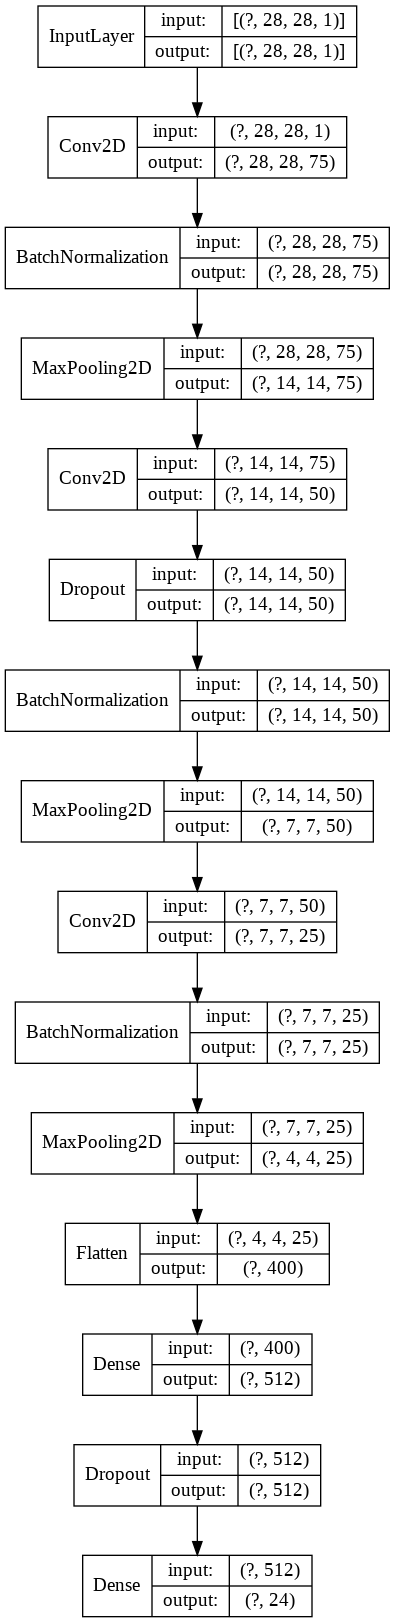

In [38]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='/content/drive/My Drive/Real time Project/model_plot.png', show_shapes=True, show_layer_names=False)

In [39]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 128) ,epochs = 20 , validation_data = (x_test, y_test) , callbacks = [learning_rate_reduction])

Epoch 1/20
215/215 [==============================] - 103s 481ms/step - loss: 1.0255 - accuracy: 0.6804 - val_loss: 3.4504 - val_accuracy: 0.1325
Epoch 2/20
215/215 [==============================] - 104s 482ms/step - loss: 0.2092 - accuracy: 0.9319 - val_loss: 1.1612 - val_accuracy: 0.6414
Epoch 3/20
215/215 [==============================] - 103s 477ms/step - loss: 0.1079 - accuracy: 0.9661 - val_loss: 0.1712 - val_accuracy: 0.9439
Epoch 4/20
215/215 [==============================] - 103s 479ms/step - loss: 0.0596 - accuracy: 0.9812 - val_loss: 0.0896 - val_accuracy: 0.9677
Epoch 5/20
215/215 [==============================] - 104s 483ms/step - loss: 0.0429 - accuracy: 0.9874 - val_loss: 0.1066 - val_accuracy: 0.9633
Epoch 6/20
215/215 [==============================] - ETA: 0s - loss: 0.0333 - accuracy: 0.9901
Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
215/215 [==============================] - 105s 489ms/step - loss: 0.0333 - accuracy: 0.9901 -

### Model Evaluation

In [42]:
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

225/225 [==============================] - 6s 25ms/step - loss: 0.0033 - accuracy: 0.9979
Accuracy of the model is -  99.79085326194763 %


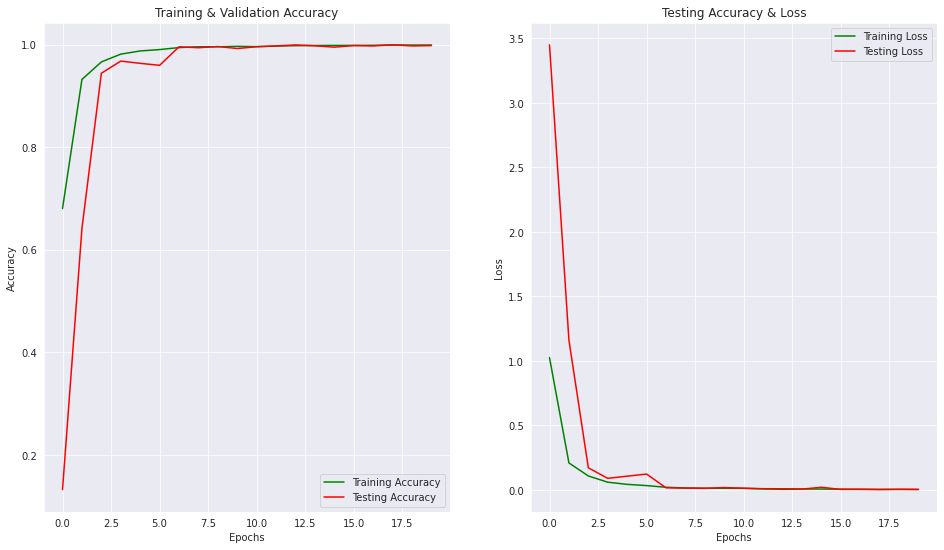

In [43]:
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(16,9)

ax[0].plot(epochs , train_acc , 'g-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'r-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-' , label = 'Testing Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [44]:
predictions = model.predict_classes(x_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [45]:
np.unique(predictions)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

In [46]:
predictions = model.predict_classes(x_test)
#handling for no j in the dataset
for i in range(len(predictions)):
    if(predictions[i] >= 9):
        predictions[i] += 1
predictions[:5]  

array([ 6,  5, 10,  0,  3])

In [47]:
cm = confusion_matrix(y,predictions)

In [48]:
cm = pd.DataFrame(cm , index = [i for i in range(25) if i != 9] , columns = [i for i in range(25) if i != 9])

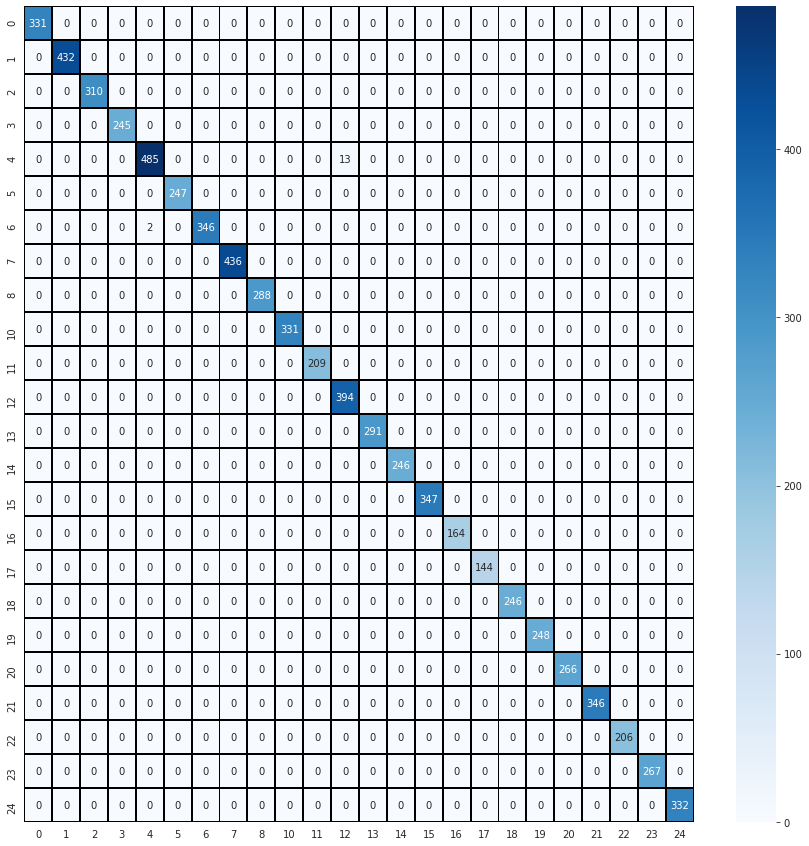

In [49]:
plt.figure(figsize = (15,15))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')

Saving the model

In [ ]:
#model.save('/content/drive/My Drive/Real time Project/asl_cnn_model', save_format = "h5")

In [ ]:
#model = keras.models.load_model('/content/drive/My Drive/Real time Project/asl_cnn_model')

### Testing the model performance on webcam images

In [52]:
path = '/content/drive/My Drive/Real time Project/'

In [57]:
def webcam_test(file_name):
  img = cv2.imread(path+file_name, 0)
  cv2_imshow(img) 
  img = cv2.resize(img, (28,28))
  img_norm = img / 255
  img_3d = img_norm.reshape(-1,28,28,1)
  prediction = model.predict_classes(img_3d)
  if prediction>=9:
    prediction +=1
  print("Predicted Letter: ", chr(ord('@')+prediction[0]+1))

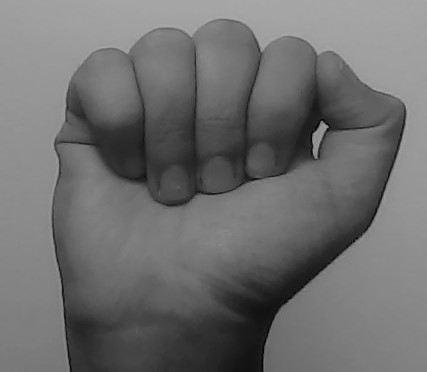

Predicted Letter:  A


In [58]:
webcam_test('A.jpg')

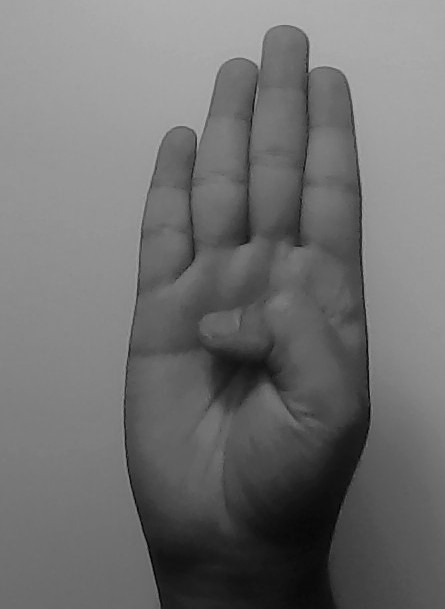

Predicted Letter:  B


In [59]:
webcam_test('B.jpg')

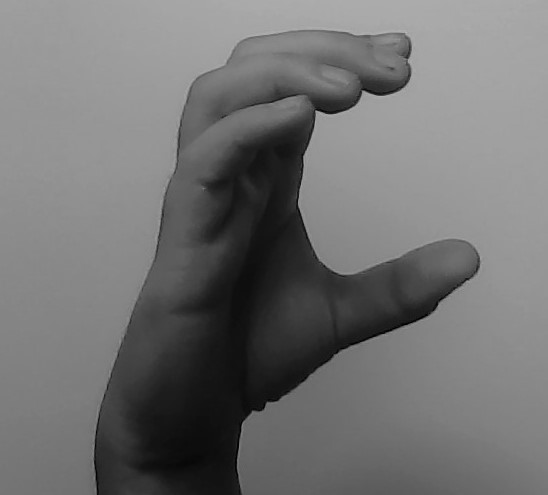

Predicted Letter:  C


In [60]:
webcam_test('C.jpg')

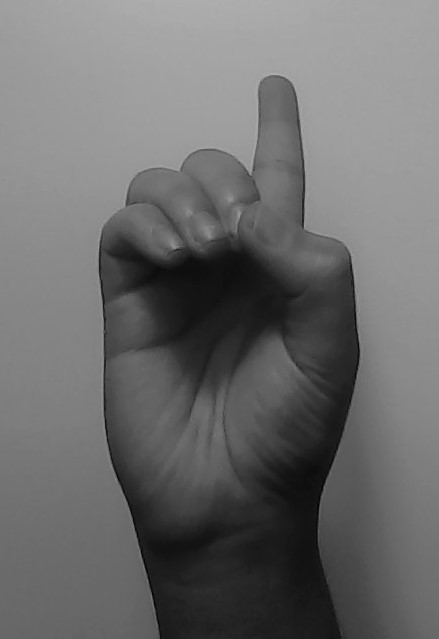

Predicted Letter:  D


In [61]:
webcam_test('D.jpg')

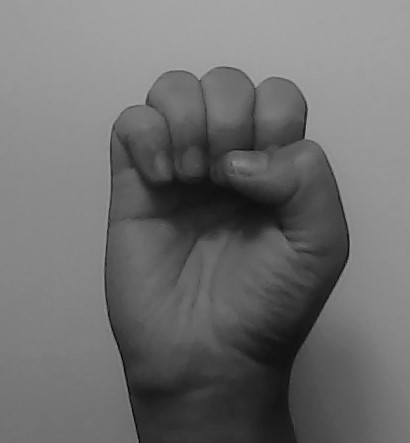

Predicted Letter:  P


In [62]:
webcam_test('E.jpg') #incorrect

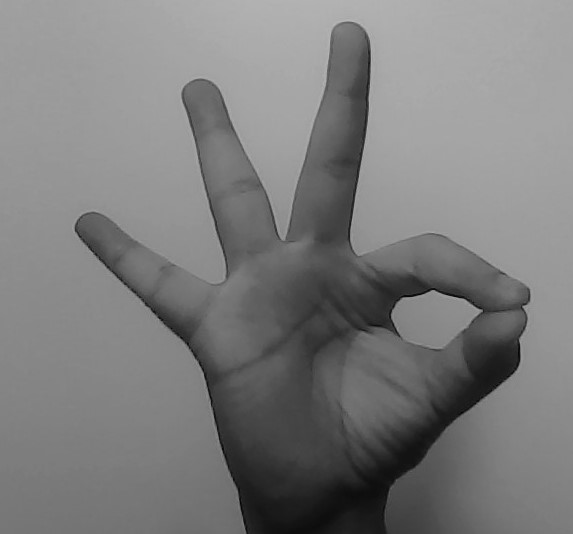

Predicted Letter:  L


In [63]:
webcam_test('F.jpg') #incorrect

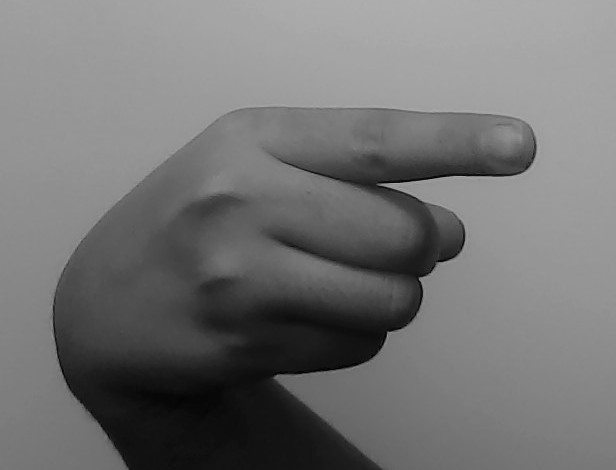

Predicted Letter:  G


In [64]:
webcam_test('G.jpg')

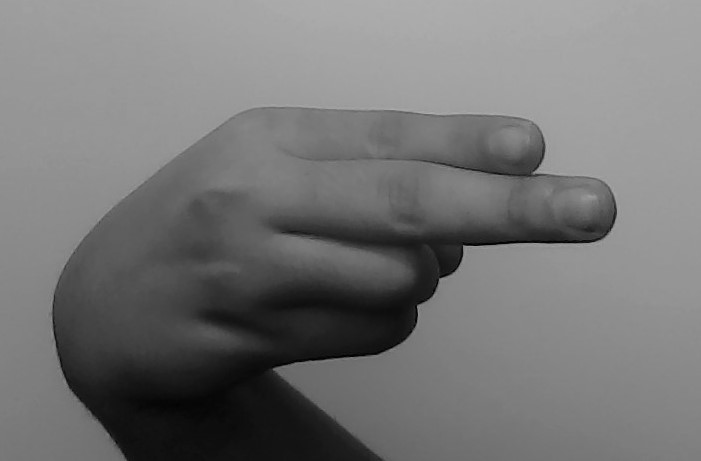

Predicted Letter:  G


In [65]:
webcam_test('H.jpg') #incorrect

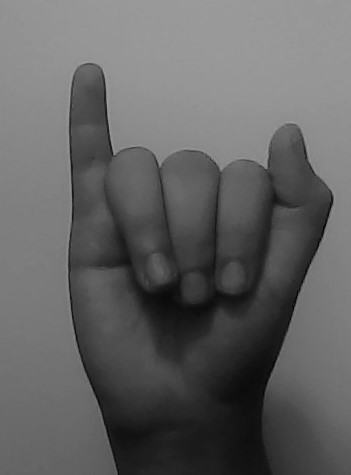

Predicted Letter:  Y


In [66]:
webcam_test('I.jpg') #incorrect

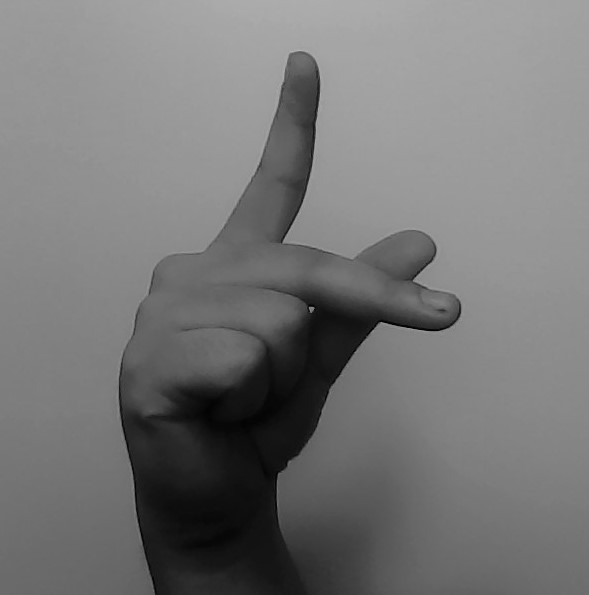

Predicted Letter:  L


In [67]:
webcam_test('K.jpg') #incorrect

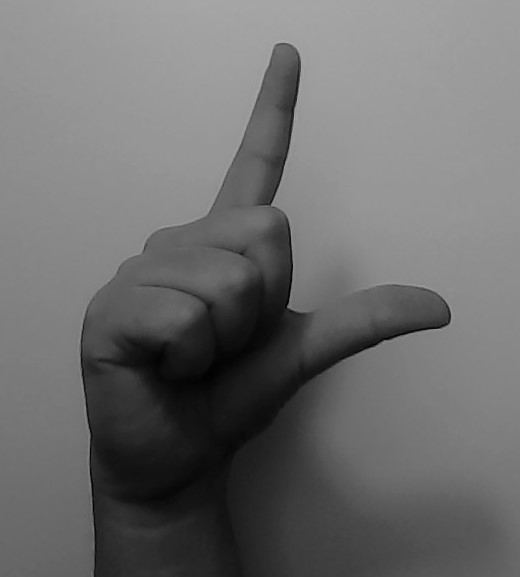

Predicted Letter:  L


In [68]:
webcam_test('L.jpg')

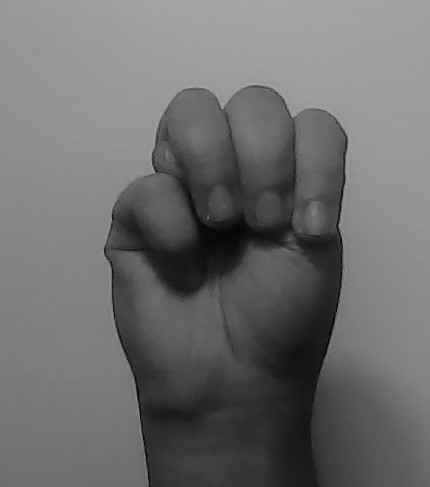

Predicted Letter:  N


In [69]:
webcam_test('M.jpg') #incorrect

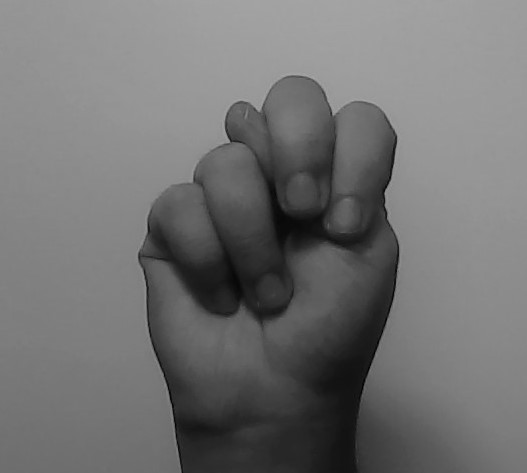

Predicted Letter:  N


In [70]:
webcam_test('N.jpg')

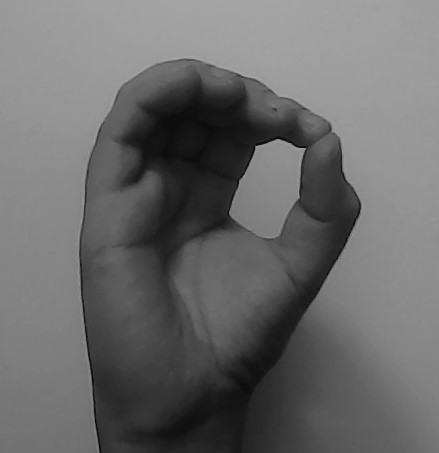

Predicted Letter:  N


In [71]:
webcam_test('O.jpg') #incorrect

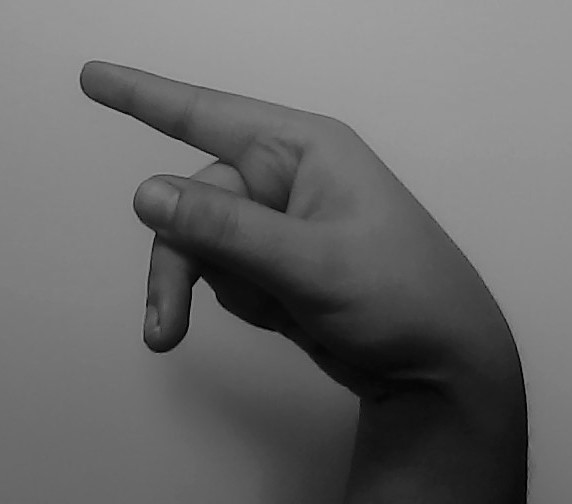

Predicted Letter:  P


In [72]:
webcam_test('P.jpg')

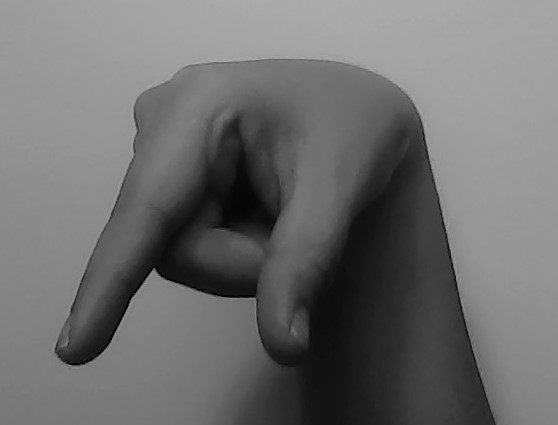

Predicted Letter:  Q


In [73]:
webcam_test('Q.jpg')

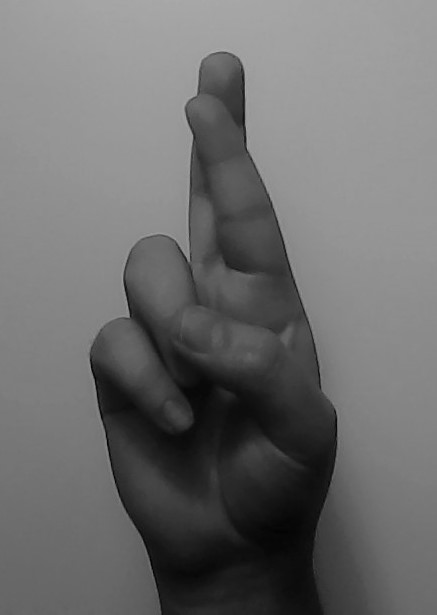

Predicted Letter:  D


In [74]:
webcam_test('R.jpg') #incorrect

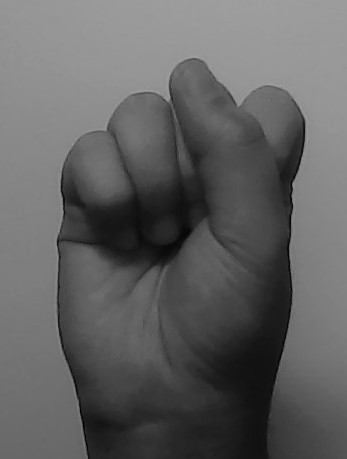

Predicted Letter:  A


In [75]:
webcam_test('S.jpg') #incorrect

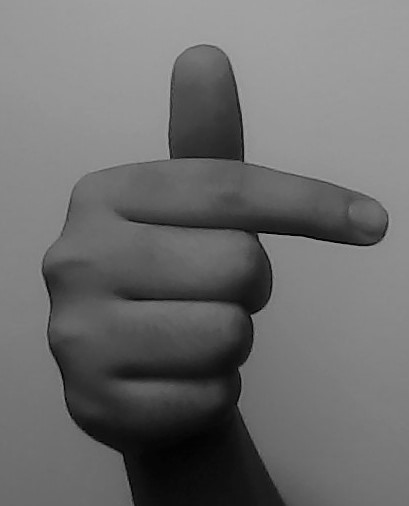

Predicted Letter:  T


In [76]:
webcam_test('T.jpg')

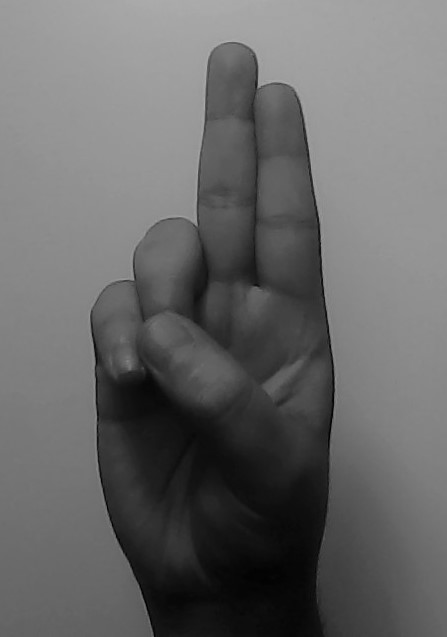

Predicted Letter:  N


In [77]:
webcam_test('U.jpg') #incorrect

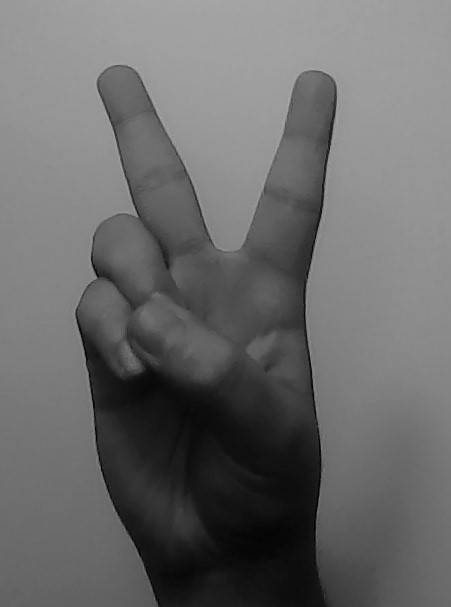

Predicted Letter:  T


In [78]:
webcam_test('V.jpg') #incorrect

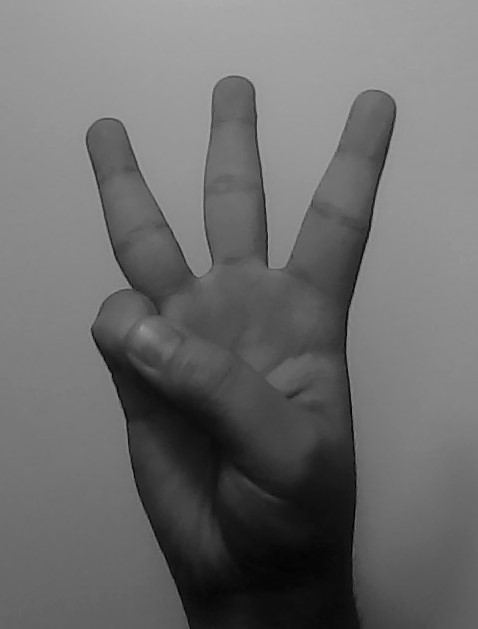

Predicted Letter:  V


In [79]:
webcam_test('W.jpg') #incorrect

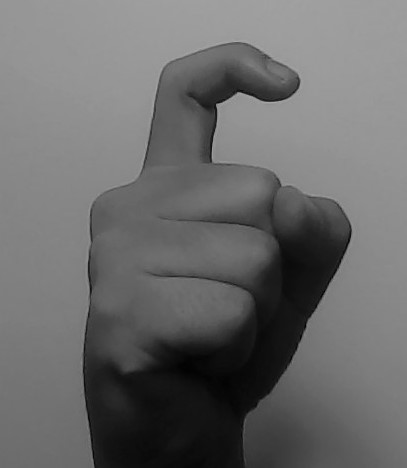

Predicted Letter:  X


In [80]:
webcam_test('X.jpg')

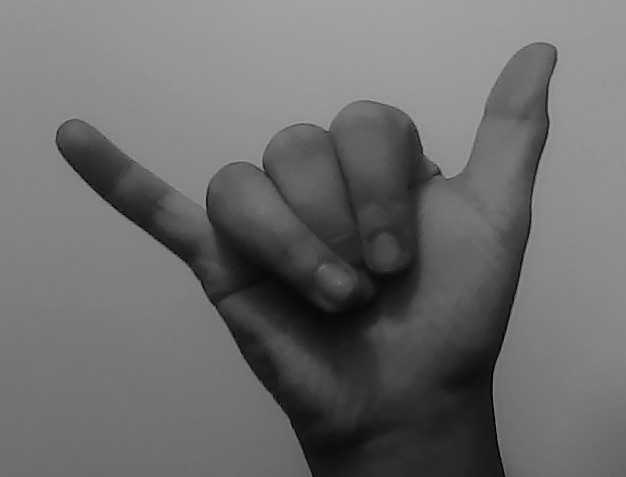

Predicted Letter:  Y


In [81]:
webcam_test('Y.jpg')